In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# Base.prepare(engine=engine, reflect=True)
Base.prepare(autoload_with=engine)
# reflect the tables


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(measurement.date)).first()
most_recent_date

('2017-08-23',)

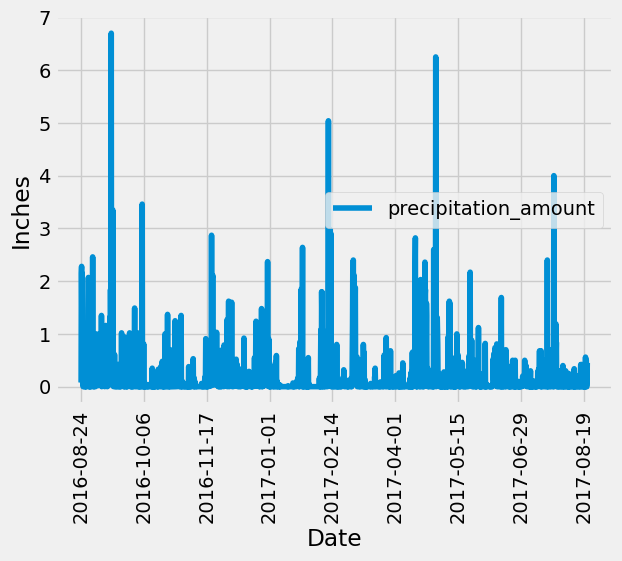

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
latest_date = dt.datetime.strptime(most_recent_date[0], '%Y-%m-%d')
# Calculate the date one year from the last date in data set.
start_date = latest_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
sel = [measurement.date, measurement.prcp]
precipitation = session.query(*sel).\
        filter(func.strftime(measurement.date) >= start_date).\
        order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation, columns=['measurement_date', 'precipitation_amount'])

# Sort the dataframe by date
precipitation_df.dropna(axis=0, how='any', inplace= True)
precipitation_df.sort_values(by='measurement_date')
precipitation_df.set_index('measurement_date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
raininch = precipitation_df.plot(rot=90, xlabel='Date', ylabel = "Inches")
plt.show()
raininch.figure.savefig('Annual_Precipitation_Hawaii.png')

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation_amount
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
precipitation_df

,precipitation_amount
measurement_date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,1.22
2016-08-24,2.15
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.00


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(station.station).count()
total_stations

9

# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

In [14]:
active_stations = session.query(measurement.station,func.count(measurement.station)).\
    order_by(func.count(measurement.station).desc()).\
    group_by(measurement.station).all()
print(active_stations)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# apply the wanted calculations, filter it all under one name
station_temp = session.query(func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs)).filter(measurement.station=="USC00519281").all()
station_temp 

[(54.0, 85.0, 71.66378066378067)]

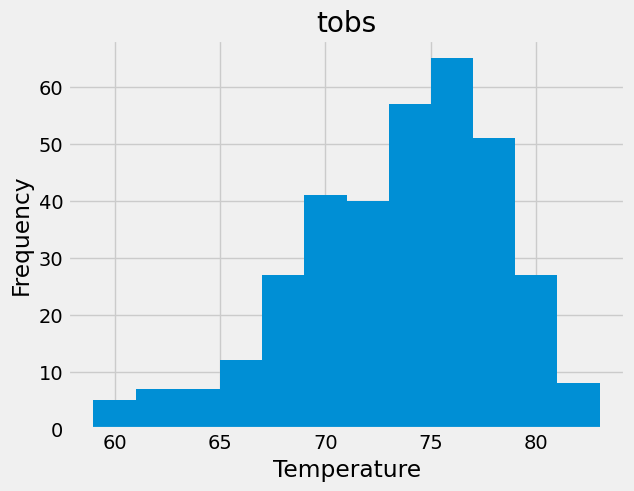

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
hist_data = session.query(measurement.tobs).\
        filter(measurement.date >= "2016-08-28")\
        .filter(measurement.station=="USC00519281").all()

#querying the database and turning it into a dataframe with this
tobs_df = pd.DataFrame(hist_data, columns=['tobs'])
# now in dataframe, aggregate

temp_hist = tobs_df.hist(bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.savefig('histogram of station temperature frequency.png')
plt.show()

# Close Session

In [17]:
# Close Session
session.close()